<a href="https://colab.research.google.com/github/DGuilherme/AAUTIA2/blob/main/CH3_Doc2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline


Doc2Vec Model
=============

Introduces Gensim's Doc2Vec model and demonstrates its use on the
`Lee Corpus <https://hekyll.services.adelaide.edu.au/dspace/bitstream/2440/28910/1/hdl_28910.pdf>`__.




# Imports


In [ ]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
# CH3 imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Doc2Vec is a `core_concepts_model` that represents each
`core_concepts_document` as a `core_concepts_vector`.  This
tutorial introduces the model and demonstrates how to train and assess it.

Here's a list of what we'll be doing:

0. Review the relevant models: bag-of-words, Word2Vec, Doc2Vec
1. Load and preprocess the training and test corpora (see `core_concepts_corpus`)
2. Train a Doc2Vec `core_concepts_model` model using the training corpus
3. Demonstrate how the trained model can be used to infer a `core_concepts_vector`
4. Assess the model
5. Test the model on the test corpus

Review: Bag-of-words
--------------------

.. Note:: Feel free to skip these review sections if you're already familiar with the models.

You may be familiar with the `bag-of-words model
<https://en.wikipedia.org/wiki/Bag-of-words_model>`_ from the
`core_concepts_vector` section.
This model transforms each document to a fixed-length vector of integers.
For example, given the sentences:

- ``John likes to watch movies. Mary likes movies too.``
- ``John also likes to watch football games. Mary hates football.``

The model outputs the vectors:

- ``[1, 2, 1, 1, 2, 1, 1, 0, 0, 0, 0]``
- ``[1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 1]``

Each vector has 10 elements, where each element counts the number of times a
particular word occurred in the document.
The order of elements is arbitrary.
In the example above, the order of the elements corresponds to the words:
``["John", "likes", "to", "watch", "movies", "Mary", "too", "also", "football", "games", "hates"]``.

Bag-of-words models are surprisingly effective, but have several weaknesses.

First, they lose all information about word order: "John likes Mary" and
"Mary likes John" correspond to identical vectors. There is a solution: bag
of `n-grams <https://en.wikipedia.org/wiki/N-gram>`__
models consider word phrases of length n to represent documents as
fixed-length vectors to capture local word order but suffer from data
sparsity and high dimensionality.

Second, the model does not attempt to learn the meaning of the underlying
words, and as a consequence, the distance between vectors doesn't always
reflect the difference in meaning.  The ``Word2Vec`` model addresses this
second problem.

Review: ``Word2Vec`` Model
--------------------------

``Word2Vec`` is a more recent model that embeds words in a lower-dimensional
vector space using a shallow neural network. The result is a set of
word-vectors where vectors close together in vector space have similar
meanings based on context, and word-vectors distant to each other have
differing meanings. For example, ``strong`` and ``powerful`` would be close
together and ``strong`` and ``Paris`` would be relatively far.

Gensim's :py:class:`~gensim.models.word2vec.Word2Vec` class implements this model.

With the ``Word2Vec`` model, we can calculate the vectors for each **word** in a document.
But what if we want to calculate a vector for the **entire document**\ ?
We could average the vectors for each word in the document - while this is quick and crude, it can often be useful.
However, there is a better way...

Introducing: Paragraph Vector
-----------------------------

.. Important:: In Gensim, we refer to the Paragraph Vector model as ``Doc2Vec``.

Le and Mikolov in 2014 introduced the `Doc2Vec algorithm <https://cs.stanford.edu/~quocle/paragraph_vector.pdf>`__,
which usually outperforms such simple-averaging of ``Word2Vec`` vectors.

The basic idea is: act as if a document has another floating word-like
vector, which contributes to all training predictions, and is updated like
other word-vectors, but we will call it a doc-vector. Gensim's
:py:class:`~gensim.models.doc2vec.Doc2Vec` class implements this algorithm.

There are two implementations:

1. Paragraph Vector - Distributed Memory (PV-DM)
2. Paragraph Vector - Distributed Bag of Words (PV-DBOW)

.. Important::
  Don't let the implementation details below scare you.
  They're advanced material: if it's too much, then move on to the next section.

PV-DM is analogous to Word2Vec CBOW. The doc-vectors are obtained by training
a neural network on the synthetic task of predicting a center word based an
average of both context word-vectors and the full document's doc-vector.

PV-DBOW is analogous to Word2Vec SG. The doc-vectors are obtained by training
a neural network on the synthetic task of predicting a target word just from
the full document's doc-vector. (It is also common to combine this with
skip-gram testing, using both the doc-vector and nearby word-vectors to
predict a single target word, but only one at a time.)

Prepare the Training and Test Data
----------------------------------

For this tutorial, we'll be training our model using the `Lee Background
Corpus
<https://hekyll.services.adelaide.edu.au/dspace/bitstream/2440/28910/1/hdl_28910.pdf>`_
included in gensim. This corpus contains 314 documents selected from the
Australian Broadcasting Corporation’s news mail service, which provides text
e-mails of headline stories and covers a number of broad topics.

And we'll test our model by eye using the much shorter `Lee Corpus
<https://hekyll.services.adelaide.edu.au/dspace/bitstream/2440/28910/1/hdl_28910.pdf>`_
which contains 50 documents.




In [ ]:
# resolver problema de gensim version
!pip install --upgrade gensim

Requirement already up-to-date: gensim in /usr/local/lib/python3.7/dist-packages (4.0.1)


In [ ]:
# Dataset Chalenge 3
# raw: https://raw.githubusercontent.com/DGuilherme/AAUTIA2/main/Doc2Vec/dataset/dataset.txt


url = 'https://raw.githubusercontent.com/DGuilherme/AAUTIA2/main/Doc2Vec/dataset/dataset.txt'
#train_data = pd.read_csv(url,delimiter=r"|")
# Dataset is now stored in a Pandas Dataframe

url10000 = 'https://raw.githubusercontent.com/DGuilherme/AAUTIA2/main/Doc2Vec/dataset/dataset10000.txt'

train_data_unsplit = pd.read_json(url10000)
train_data_unsplit = train_data_unsplit.rename(columns={'_id': 'ID', 'abstract': 'Resumo','title': 'Titulo'})
train_data_unsplit = train_data_unsplit.dropna()
train_data_unsplit = train_data_unsplit.drop_duplicates(subset ="Resumo",keep = False)
train_data_unsplit = train_data_unsplit.drop_duplicates(subset ="Titulo",keep = False)


from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(train_data_unsplit, test_size=0.2)

In [ ]:
train_data[train_data.duplicated(subset=['Titulo'],keep=False)]




,ID,Resumo,Titulo


In [ ]:
test_data.describe()

,ID,Resumo,Titulo
count,1939,1939,1939
unique,1939,1939,1939
top,57025eb6eb1ec9f5515f8cc4,"4H-pyrido[3,2-a]-1,3,2-dioxaphosphorin compoun...",Fuel oil supply means
freq,1,1,1


In [ ]:

import gensim
def tagData(dataframe):
  number = 0
  for index,row in dataframe.iterrows():
    number = number + 1
    resumotokens = gensim.utils.simple_preprocess(row['Resumo'])
    #titulotokens = gensim.utils.simple_preprocess(row['Titulo'])

    yield gensim.models.doc2vec.TaggedDocument(resumotokens, [number]) #yield gensim.utils.simple_preprocess(row['Resumo'])


vocabulary = list(tagData(train_data))
vocabulary_test = list(tagData(test_data))


93.0

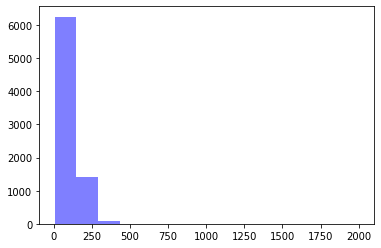

In [ ]:
text_length = [len(entry.words) for entry in vocabulary]
plt.hist(text_length, facecolor='blue', alpha=0.5, bins= 'sturges')
import numpy as np
np.median( text_length)

In [ ]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=2, epochs=250) # Create inital empty model

2021-04-11 16:58:38,190 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec(dm/m,d100,n5,w5,mc2,s0.001,t3)', 'datetime': '2021-04-11T16:58:38.190242', 'gensim': '4.0.1', 'python': '3.7.10 (default, Feb 20 2021, 21:17:23) \n[GCC 7.5.0]', 'platform': 'Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}


Build a vocabulary



In [ ]:
model.build_vocab(vocabulary) # Add data to the model

2021-04-11 16:58:39,863 : INFO : collecting all words and their counts
2021-04-11 16:58:39,864 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2021-04-11 16:58:40,019 : INFO : collected 19930 word types and 7753 unique tags from a corpus of 7752 examples and 830795 words
2021-04-11 16:58:40,021 : INFO : Creating a fresh vocabulary
2021-04-11 16:58:40,087 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=2 retains 13185 unique words (66.15654791771199%% of original 19930, drops 6745)', 'datetime': '2021-04-11T16:58:40.087365', 'gensim': '4.0.1', 'python': '3.7.10 (default, Feb 20 2021, 21:17:23) \n[GCC 7.5.0]', 'platform': 'Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'prepare_vocab'}
2021-04-11 16:58:40,090 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=2 leaves 824050 word corpus (99.18812703494845%% of original 830795, drops 6745)', 'datetime': '2021-04-11T16:58:40.090719', 'gensim': '4.0.1', 'python': '3.7.10 (

Essentially, the vocabulary is a list (accessible via
``model.wv.index_to_key``) of all of the unique words extracted from the training corpus.
Additional attributes for each word are available using the ``model.wv.get_vecattr()`` method,
For example, to see how many times ``penalty`` appeared in the training corpus:




In [ ]:
print("Word 'penalty' appeared {model.wv.get_vecattr('penalty', 'count')} times in the training corpus.")

Word 'penalty' appeared {model.wv.get_vecattr('penalty', 'count')} times in the training corpus.


Next, train the model on the corpus.
If optimized Gensim (with BLAS library) is being used, this should take no more than 3 seconds.
If the BLAS library is not being used, this should take no more than 2
minutes, so use optimized Gensim with BLAS if you value your time.




In [ ]:
model.train(vocabulary, total_examples=model.corpus_count, epochs=model.epochs)

2021-04-11 16:58:43,048 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 3 workers on 13185 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=5', 'datetime': '2021-04-11T16:58:43.048261', 'gensim': '4.0.1', 'python': '3.7.10 (default, Feb 20 2021, 21:17:23) \n[GCC 7.5.0]', 'platform': 'Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'train'}
2021-04-11 16:58:44,074 : INFO : EPOCH 1 - PROGRESS: at 51.63% examples, 313303 words/s, in_qsize 6, out_qsize 0
2021-04-11 16:58:44,906 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-04-11 16:58:44,935 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-04-11 16:58:44,948 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-04-11 16:58:44,949 : INFO : EPOCH - 1 : training on 830795 raw words (620697 effective words) took 1.9s, 328295 effective words/s
2021-04-11 16:58:45,963 : INFO : EPOCH 2 - PROGRESS: at 52.81% examples, 325334 words

Now, we can use the trained model to infer a vector for any piece of text
by passing a list of words to the ``model.infer_vector`` function. This
vector can then be compared with other vectors via cosine similarity.




In [ ]:
vector = model.infer_vector(['overspeed', 'shutoff' ,'device', 'for' ,'use'])
print(vector)

[-0.05825176  0.16630377 -0.02105731 -0.2799375  -0.10948098 -0.8030195
  0.24233924  0.45645294 -0.43708667 -0.5628144  -0.11347102 -0.7094829
  0.19024613 -0.26199418 -0.08262871 -0.59829277  0.4979767  -0.5449416
 -0.06848434 -0.88685775  0.34582058  0.60544926  0.31250137 -0.24445209
  0.6932857  -0.17822915  0.22464672 -0.27845153 -0.62746304 -0.49260715
  0.6106277  -0.03254032  0.05426909 -0.33270058  0.22776899  1.0023441
  0.30757335 -0.18326981 -0.01769478 -0.11753915 -0.18956502 -0.45760557
 -0.42545837 -0.00267922  0.09671977 -0.35659727  0.17279308  0.22071406
  0.28555837  0.44421393 -0.26080212 -0.37547082  0.08818948  0.0051465
  0.00323167  0.20986286 -0.01163498 -0.28262    -0.14172237  0.21929975
  0.37699586 -0.26327097  0.06804948 -0.02751029  0.74991316  0.25855896
 -0.53785634  0.24781266 -0.788686    0.3015872  -0.5257948   0.3974501
  0.34833637  0.23348817 -0.3458476  -0.08130516  0.21879952 -0.4687636
 -0.13709609 -0.26401243 -0.4548971  -0.00546703  0.019034

Note that ``infer_vector()`` does *not* take a string, but rather a list of
string tokens, which should have already been tokenized the same way as the
``words`` property of original training document objects.

Also note that because the underlying training/inference algorithms are an
iterative approximation problem that makes use of internal randomization,
repeated inferences of the same text will return slightly different vectors.




Assessing the Model
-------------------

To assess our new model, we'll first infer new vectors for each document of
the training corpus, compare the inferred vectors with the training corpus,
and then returning the rank of the document based on self-similarity.
Basically, we're pretending as if the training corpus is some new unseen data
and then seeing how they compare with the trained model. The expectation is
that we've likely overfit our model (i.e., all of the ranks will be less than
2) and so we should be able to find similar documents very easily.
Additionally, we'll keep track of the second ranks for a comparison of less
similar documents.




In [ ]:
ranks = []
second_ranks = []
for doc_id in range(len(vocabulary)):
    inferred_vector = model.infer_vector(vocabulary[doc_id].words) # uses the model to create the vector
    sims = model.dv.most_similar([inferred_vector], topn=len(model.dv)) # similaridade  
    rank = [docid for docid, sim in sims].index(doc_id) 
    ranks.append(rank)

    second_ranks.append(sims[1])

Let's count how each document ranks with respect to the training corpus

NB. Results vary between runs due to random seeding and very small corpus



In [ ]:
import collections

counter = collections.Counter(ranks)
print(counter)

Counter({6223: 6, 622: 6, 9885: 5, 45: 5, 7376: 5, 9941: 5, 6756: 5, 3343: 5, 1579: 5, 1877: 5, 7281: 5, 4157: 5, 3420: 5, 3765: 4, 4552: 4, 8046: 4, 5806: 4, 6745: 4, 3626: 4, 2720: 4, 4994: 4, 5718: 4, 4926: 4, 7594: 4, 8135: 4, 4283: 4, 1911: 4, 8811: 4, 7849: 4, 5286: 4, 2144: 4, 573: 4, 28: 4, 7562: 4, 5173: 4, 4471: 4, 1273: 4, 3651: 4, 4456: 4, 1711: 4, 6896: 4, 829: 4, 278: 4, 3153: 4, 4277: 4, 8841: 4, 9377: 4, 4573: 4, 1550: 4, 481: 4, 7941: 4, 6957: 4, 8221: 4, 8178: 4, 7283: 4, 3081: 4, 9629: 4, 5826: 4, 5510: 4, 9435: 4, 7665: 4, 3960: 4, 6972: 4, 2029: 4, 7150: 4, 6869: 4, 4280: 4, 868: 4, 4974: 4, 6585: 4, 599: 4, 3381: 4, 2285: 4, 3271: 4, 9834: 4, 1977: 4, 8059: 4, 5066: 4, 5236: 4, 9453: 4, 295: 4, 5848: 4, 8715: 4, 1489: 4, 3107: 4, 9645: 4, 5682: 4, 5252: 4, 4543: 4, 6746: 4, 3469: 3, 1404: 3, 1007: 3, 3552: 3, 8149: 3, 915: 3, 7944: 3, 790: 3, 5544: 3, 1123: 3, 3312: 3, 2077: 3, 5375: 3, 9279: 3, 3011: 3, 6922: 3, 3136: 3, 6554: 3, 7960: 3, 3415: 3, 2041: 3, 5670: 

Basically, greater than 95% of the inferred documents are found to be most
similar to itself and about 5% of the time it is mistakenly most similar to
another document. Checking the inferred-vector against a
training-vector is a sort of 'sanity check' as to whether the model is
behaving in a usefully consistent manner, though not a real 'accuracy' value.

This is great and not entirely surprising. We can take a look at an example:




In [ ]:
doc_id = random.randint(0, len(vocabulary) - 1)
print('Document ({}): «{}»\n'.format(doc_id, ' '.join(vocabulary[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)


Document (2995): «case for displaying notices having body including translucent front face appropriate sealingly interconnected walls the bottom wall having an access opening removable shutter for closing the opening above the front face drum on which is mounted rollable flexible element adapted to pass through the opening the flexible element being provided with means for attaching notice so that the latter is situated in an extension and beyond the rollable element the drum being rotatable for winding and unwinding and means for arresting the drum when the attaching means have passed beyond the bottom wall toward the outside and when the same means have attained height at which the notice is exposed through the translucent front face so as to prevent the notice from being rolled up on the drum»

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec(dm/m,d50,n5,w5,mc2,s0.001,t3):

MOST (3563, 0.9628444314002991): «the invention relates to cover for toilet tank which is both decorative and which e

Notice above that the most similar document (usually the same text) is has a
similarity score approaching 1.0. However, the similarity score for the
second-ranked documents should be significantly lower (assuming the documents
are in fact different) and the reasoning becomes obvious when we examine the
text itself.

We can run the next cell repeatedly to see a sampling other target-document
comparisons.




In [ ]:
print(train_data.iloc[499]['Titulo'],' | ',train_data.iloc[499]['Resumo'])

print(train_data.iloc[496]['Titulo'],' | ',train_data.iloc[496]['Resumo'])

print(train_data.iloc[181]['Titulo'],' | ',train_data.iloc[181]['Resumo'])





 Rotary displacement pumps   |   A rotary positive displacement pump of the internally-meshing screw type having a stator, a rotor and an inlet or outlet chamber at one end of the rotor has a drive comprising a connecting member rigidly secured to the rotor and extending through the chamber, which connecting member, beyond the end of the chamber remote from the rotor, is joined by a connecting rod with two universal joints to a drive shaft, connecting member in the chamber being supported by a bearing flexibly carried on a resilient support member which is sealed to the outer race of the bearing and also to the chamber wall.
 Apparatus for use as a gas compressor or gas blower   |   A gas compressor or blower comprising a cylinder having air intake and exhaust ports; a piston which is rotatably and reciprocably movable in the cylinder; valve means for admitting air into and exhausting air from at least one chamber lying to one side of the piston; a piston shaft to which the piston is s

In [ ]:
# Pick a random document from the corpus and infer a vector from the model
import random


doc_id = random.randint(0, len(vocabulary_test) - 1)

inferred_vector = model.infer_vector(vocabulary_test[doc_id].words) # uses the model to create the vector
sims = model.dv.most_similar([inferred_vector], topn=len(model.dv)) # similaridade 
print(sims)
for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
  print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(vocabulary[sims[index][0]].words)))

[('opaque', 0.7085800170898438), ('shade', 0.6906930208206177), ('vernier', 0.6079248189926147), ('fin', 0.5760194659233093), ('carbureted', 0.564963161945343), ('blush', 0.5601942539215088), ('photoemitters', 0.5471093654632568), ('fishline', 0.5424595475196838), ('pivoting', 0.5388104319572449), ('systematically', 0.5315121412277222), ('age', 0.5254471302032471), ('extractor', 0.5226413011550903), ('zoned', 0.522474467754364), ('focal', 0.5222833752632141), ('cemented', 0.5144048929214478), ('asynchronous', 0.5134984254837036), ('bilaminar', 0.5035114288330078), ('flexural', 0.4999232888221741), ('erectable', 0.49963513016700745), ('ophthalmometer', 0.49695125222206116), ('winch', 0.49566957354545593), ('pentenyl', 0.49316826462745667), ('unit', 0.4923279285430908), ('sanitizer', 0.4911424517631531), ('plane', 0.4905197322368622), ('intercepting', 0.4900919795036316), ('cameras', 0.4883441925048828), ('cyclohexenenes', 0.4881956875324249), ('film', 0.4834246039390564), ('collapsable'

Testing the Model
-----------------

Using the same approach above, we'll infer the vector for a randomly chosen
test document, and compare the document to our model by eye.




In [ ]:
# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(vocabulary_test) - 1)
inferred_vector = model.infer_vector(vocabulary_test[doc_id].words)
sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))
print(sims)
print(doc_id)

# Compare and print the most/median/least similar documents from the train corpus
print('Test Document ({}): «{}»\n'.format(doc_id, ' '.join(vocabulary_test[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0),('Second', 1),('Third', 2), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(vocabulary[sims[index][0]].words)))

[(984, 0.44939279556274414), (1195, 0.4353058338165283), (643, 0.4204864501953125), (3678, 0.4198797643184662), (1813, 0.410763144493103), (5694, 0.40441203117370605), (24, 0.39989474415779114), (1208, 0.39461663365364075), (7333, 0.3931242823600769), (792, 0.38845381140708923), (1571, 0.3883964717388153), (7062, 0.3869497776031494), (1820, 0.3858932852745056), (605, 0.38534653186798096), (1667, 0.3814465403556824), (1778, 0.3811235725879669), (6279, 0.3803842067718506), (5403, 0.37865257263183594), (7263, 0.3773868680000305), (1956, 0.37593385577201843), (684, 0.37351295351982117), (1967, 0.3725515604019165), (5509, 0.37076088786125183), (4913, 0.36656081676483154), (1080, 0.36515700817108154), (6197, 0.36497193574905396), (7234, 0.36489343643188477), (6328, 0.3646547496318817), (5543, 0.36217546463012695), (6587, 0.3617485463619232), (5507, 0.3605080842971802), (3420, 0.359859436750412), (2554, 0.3592163026332855), (2392, 0.3576584458351135), (2532, 0.3572116494178772), (387, 0.35660

Conclusion
----------

Let's review what we've seen in this tutorial:

0. Review the relevant models: bag-of-words, Word2Vec, Doc2Vec
1. Load and preprocess the training and test corpora (see `core_concepts_corpus`)
2. Train a Doc2Vec `core_concepts_model` model using the training corpus
3. Demonstrate how the trained model can be used to infer a `core_concepts_vector`
4. Assess the model
5. Test the model on the test corpus

That's it! Doc2Vec is a great way to explore relationships between documents.

Additional Resources
--------------------

If you'd like to know more about the subject matter of this tutorial, check out the links below.

* `Word2Vec Paper <https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf>`_
* `Doc2Vec Paper <https://cs.stanford.edu/~quocle/paragraph_vector.pdf>`_
* `Dr. Michael D. Lee's Website <http://faculty.sites.uci.edu/mdlee>`_
* `Lee Corpus <http://faculty.sites.uci.edu/mdlee/similarity-data/>`__
* `IMDB Doc2Vec Tutorial <doc2vec-IMDB.ipynb>`_


